In [1]:
import numpy as np
import scipy as sp
from scipy.constants import c, e, h
from scipy.optimize import curve_fit, root
from scipy.odr import Model, RealData, ODR
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
blu=pd.read_csv('Blu.txt', names=['vx', 'vy', 'err_x', 'err_y'], skiprows=1)
blu['led']='blu'
giallo=pd.read_csv('Giallo.txt', names=['vx', 'vy', 'err_x', 'err_y'], skiprows=1)
giallo['led']='giallo'
rosso=pd.read_csv('Rosso.txt', names=['vx', 'vy', 'err_x', 'err_y'], skiprows=1)
rosso['led']='rosso'
verde=pd.read_csv('Verde.txt', names=['vx', 'vy', 'err_x', 'err_y'], skiprows=1)
verde['led']='verde'
viola=pd.read_csv('Viola.txt', names=['vx', 'vy', 'err_x', 'err_y'], skiprows=1)
viola['led']='viola'
led=pd.DataFrame([[471.6e-9, 13.6e-9], [585.8e-9, 15.1e-9], [630.9e-9, 18.9e-9], [563.2e-9, 11.8e-9], [403e-9, 5.8e-9]], columns=['lambda', 'err_lambda'], index=['blu', 'giallo', 'rosso', 'verde', 'viola'])
led['freq']=c/led['lambda']
led['err_freq']=led['freq']/led['lambda']*led['err_lambda']
led['intersezione']=np.nan
led['err_intersezione']=np.nan

In [3]:
data=pd.concat([blu, giallo, rosso, verde, viola])
data['vy']=data['vy']*1e-3
data['err_y']=data['err_y']*1e-4

In [4]:
def exponential(x, a, b ,c):
    return a + b*np.exp(-x*c)

def linear(x, p, q):
    return x*p+q

blu intersezione: 1.661578589990498 ± 0.10533198474979998
giallo intersezione: 1.1341530099911896 ± 0.06439194888871375
rosso intersezione: 1.0125930106213898 ± 0.15388884212492882
verde intersezione: 1.242970721479665 ± 0.06260818146618215
viola intersezione: 2.0713217746698516 ± 0.09620978502820798


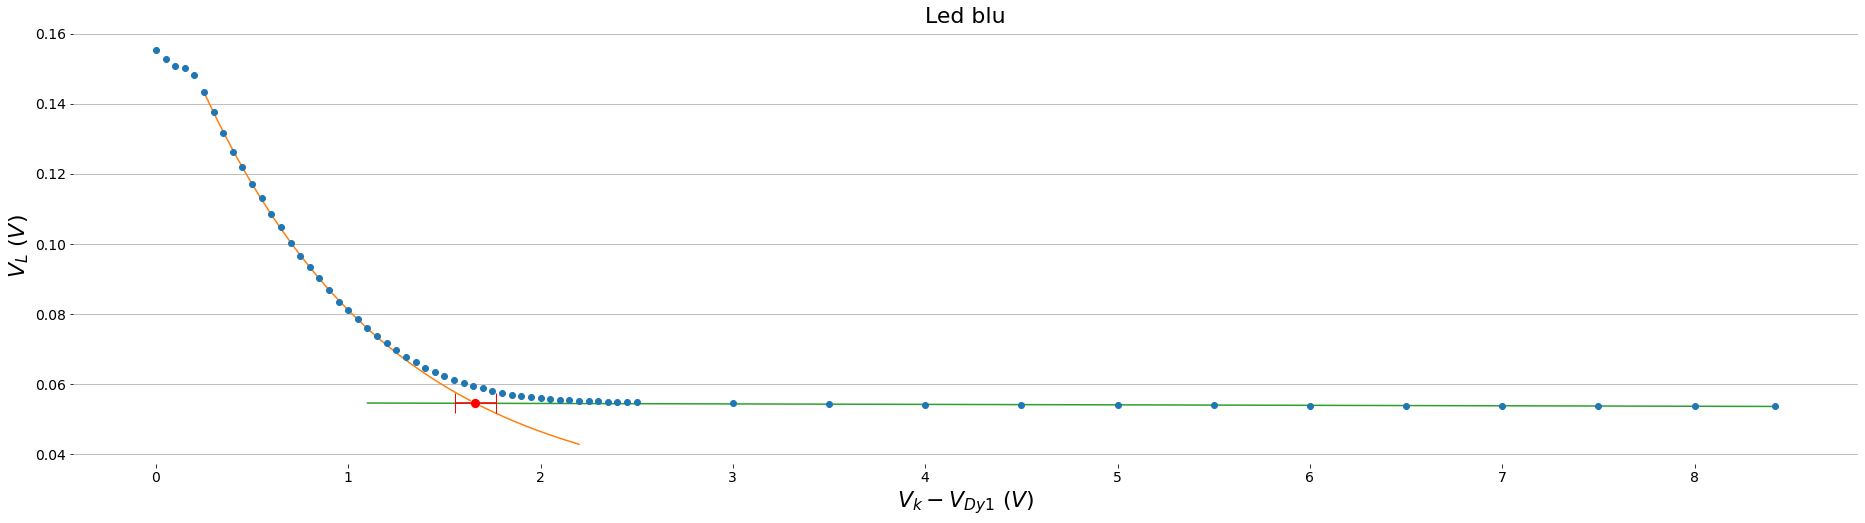

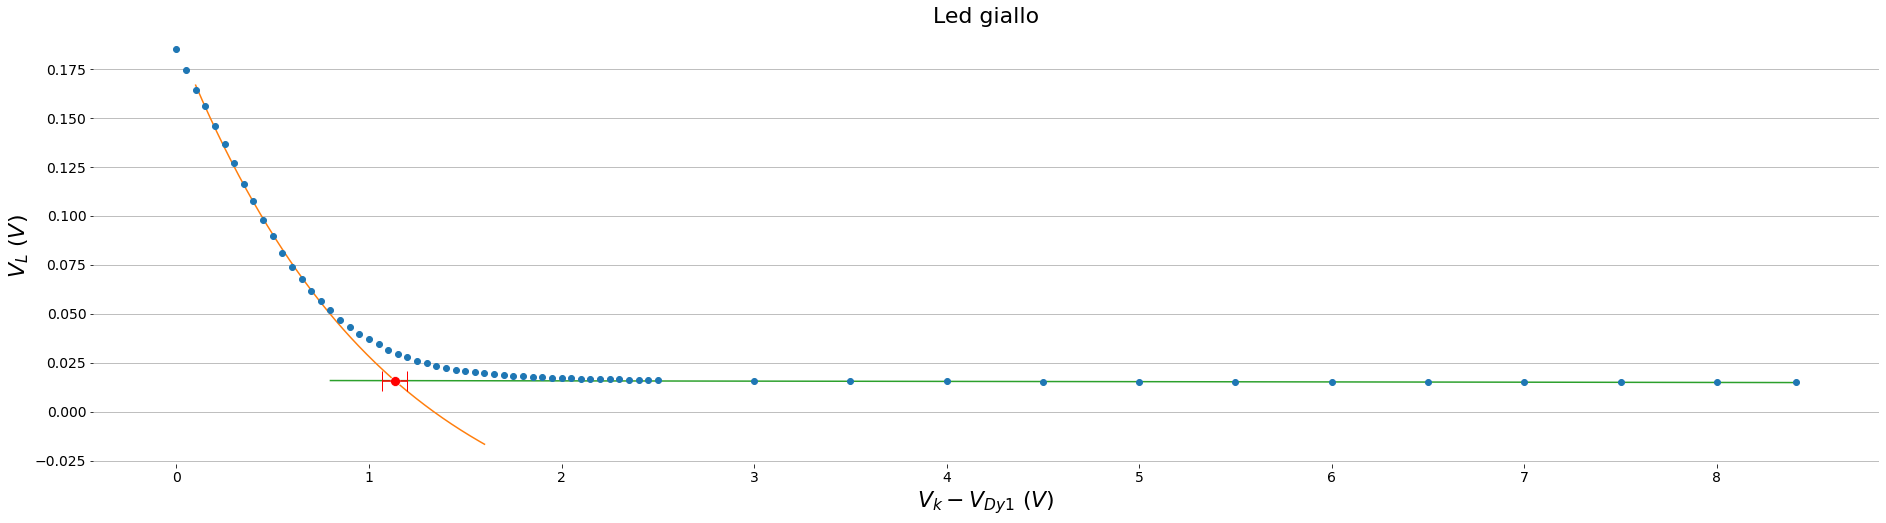

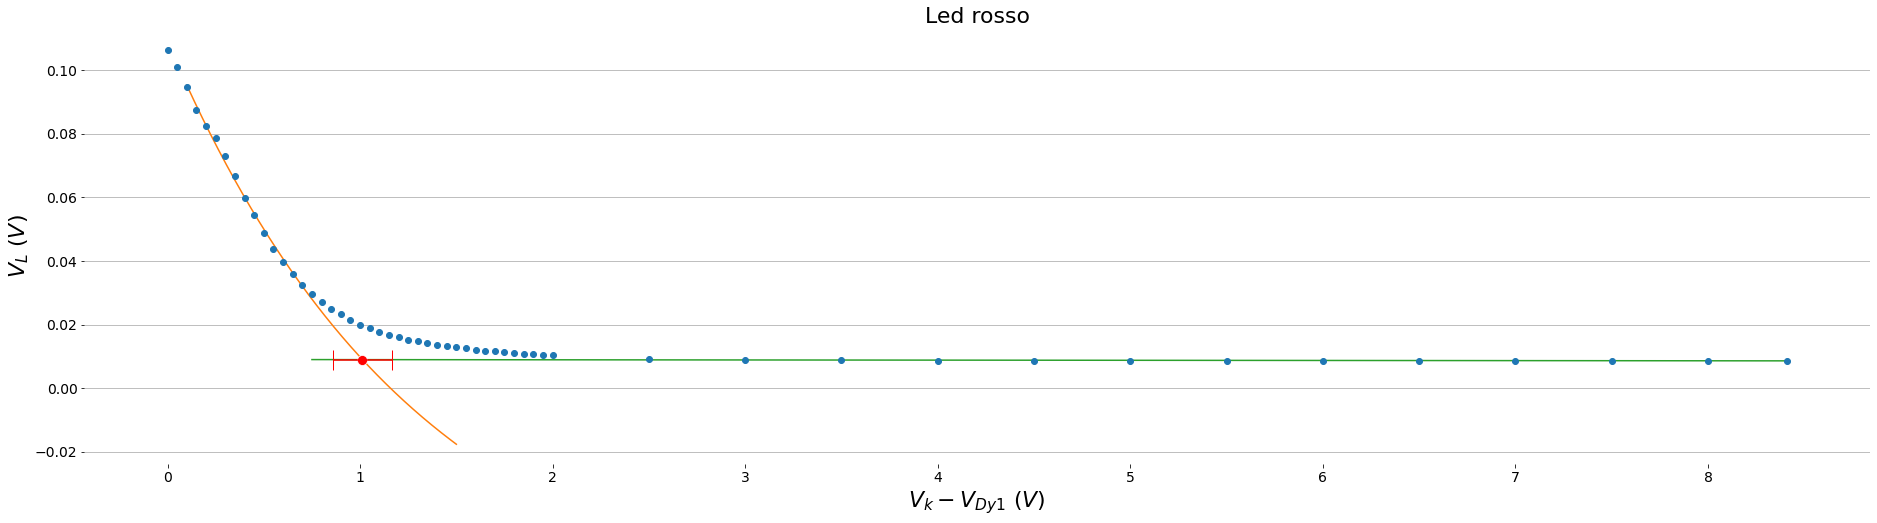

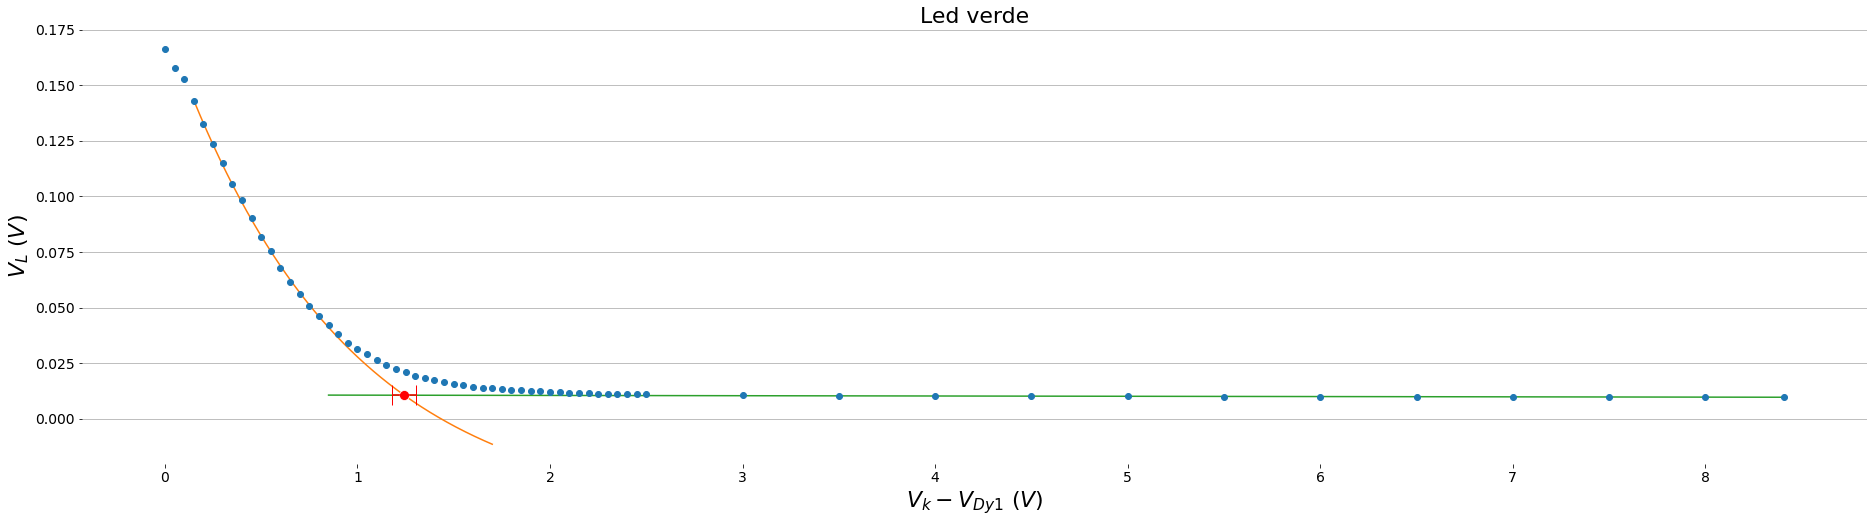

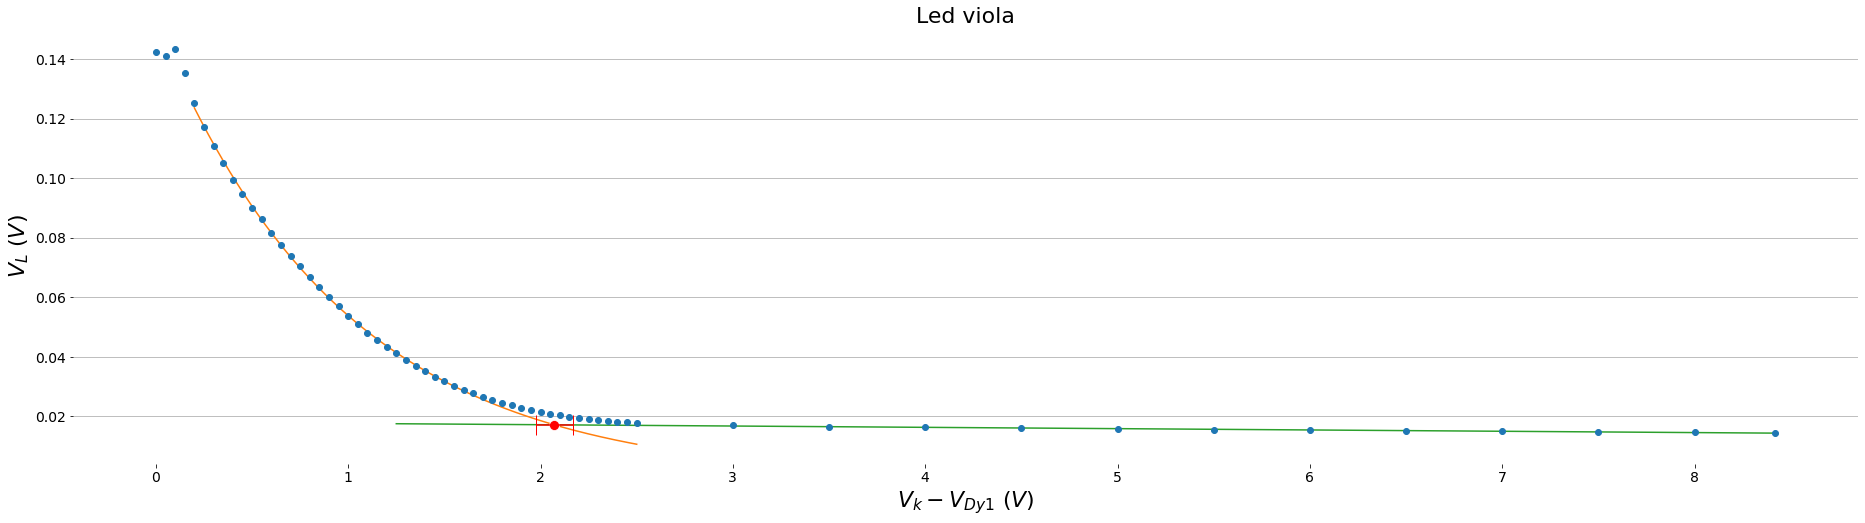

In [5]:
for color in led.index:
    df=data[data['led']==color]

    y_max=np.ptp(df['vy'])*0.9+df['vy'].min()
    y_min=np.ptp(df['vy'])*0.2+df['vy'].min()
    maske=np.logical_and(df['vy']<y_max, df['vy']>y_min)
    popte, pcove = curve_fit(exponential, df[maske]['vx'], df[maske]['vy'], absolute_sigma=True, sigma = df[maske]['err_y'])
    st_errore=np.sqrt(np.diag(pcove))
    xe=np.linspace(df[maske]['vx'].min(), df[maske]['vx'].max()*2, 1000)
    ye=exponential(xe, *popte)

    maskl=df['vx'].diff()>0.1
    poptl, pcovl = curve_fit(linear, df[maskl]['vx'], df[maskl]['vy'], absolute_sigma=True, sigma = df[maskl]['err_y'])
    st_errorl=np.sqrt(np.diag(pcovl))
    xl=np.linspace(df[maske]['vx'].max(), df[maskl]['vx'].max(),1000)
    yl=linear(xl, *poptl)

    def calcola_intersezione(a, b, c, p, q):
        func = lambda x : linear(x, p, q) - exponential(x, a, b, c)
        sol = root(func, x0=1)
        return sol.x
    sol=calcola_intersezione(*popte, *poptl)

    def derivative(*args):
        d=[]
        for i in range(len(args)):
            temp1=list(args)
            temp2=list(args)
            temp1[i]=temp1[i]+temp1[i]*1e-3
            temp2[i]=temp2[i]-temp2[i]*1e-3
            x1=calcola_intersezione(*temp1)
            x2=calcola_intersezione(*temp2)
            dx=(x1-x2)/(2*args[i]*1e-3)
            d.append(abs(dx)[0])
        return np.array(d)

    d=derivative(*popte, *poptl)
    errors=np.concatenate((st_errore,st_errorl))
    params=np.concatenate((popte, poptl))
    err_sol=np.sqrt((d*errors)**2).sum()
    led['intersezione'].loc[color]=sol
    led['err_intersezione'].loc[color]=err_sol
    print(f'{color} intersezione: {sol[0]} ± {err_sol}')
    
    fig, ax1 = plt.subplots(nrows=1, ncols = 1, figsize = (32,8))
    ax1.grid(axis = 'y')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.errorbar(x=df['vx'], y=df['vy'], xerr=df['err_x'], yerr=df['err_y'], fmt='o')
    sns.lineplot(x=xe, y=ye, ax=ax1)
    sns.lineplot(x=xl, y=yl, ax=ax1)
    sns.lineplot(x=sol, y=linear(sol, *poptl), marker='o', markersize=10, color='red')
    ax1.errorbar(x=sol, y=linear(sol, *poptl), xerr=err_sol, capsize=10, color='red', fmt='o')
    #ax1.axhline(y=y_max, linestyle='--')
    #ax1.axhline(y=y_min, linestyle='--')
    ax1.set_ylabel(r'$V_L\ (V)$', fontsize = 22)
    ax1.set_xlabel(r'$V_k - V_{Dy1}\ (V)$', fontsize = 22)
    ax1.set_title(f'Led {color}', fontsize=22)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.savefig(f'{color}.svg', bbox_inches = "tight")

In [6]:
led['energia']=h*led['freq']/e
led['err_energia']=led['err_freq']*h/e
led

,lambda,err_lambda,freq,err_freq,intersezione,err_intersezione,energia,err_energia
blu,4.716000e-07,1.360000e-08,6.356922e+14,1.833209e+13,1.661579,0.105332,2.629012,0.075815
giallo,5.858000e-07,1.510000e-08,5.117659e+14,1.319164e+13,1.134153,0.064392,2.116494,0.054556
rosso,6.309000e-07,1.890000e-08,4.751822e+14,1.423513e+13,1.012593,0.153889,1.965196,0.058872
verde,5.632000e-07,1.180000e-08,5.323019e+14,1.115263e+13,1.242971,0.062608,2.201424,0.046124
viola,4.030000e-07,5.800000e-09,7.439019e+14,1.070628e+13,2.071322,0.096210,3.076531,0.044278


In [7]:
popt, pcov = curve_fit(linear, led['freq'], led['intersezione'], absolute_sigma=False, sigma = led['err_intersezione'])
st_error=np.sqrt(np.diag(pcov))
x=np.linspace(led['freq'].min(), led['freq'].max(), 1000)
y=linear(x, *popt)
print(f'valore di h: {popt[0]*e} ± {st_error[0]*e}')
print(f'potenziale di lavoro: {popt[1]} ± {st_error[1]}')

valore di h: 6.421288044920311e-34 ± 1.4154447580031895e-35
potenziale di lavoro: -0.9015522211840278 ± 0.05055037430677966


In [8]:
def f(B, x):
    return B[0]*x + B[1]

linear = Model(f)
data = RealData(led['freq'], led['intersezione'], sx=led['err_freq'], sy=led['err_intersezione'])
odr=ODR(data, linear, beta0=[h/e, 1])
output=odr.run()
print(f'h con odr: {output.beta[0]*e} ± {output.sd_beta[0]*e}')
print(f'intercetta con odr: {output.beta[1]} ± {output.sd_beta[1]}')

h con odr: 6.404407496707256e-34 ± 1.2886907313399752e-35
intercetta con odr: -0.8951493777957454 ± 0.046626676487683476


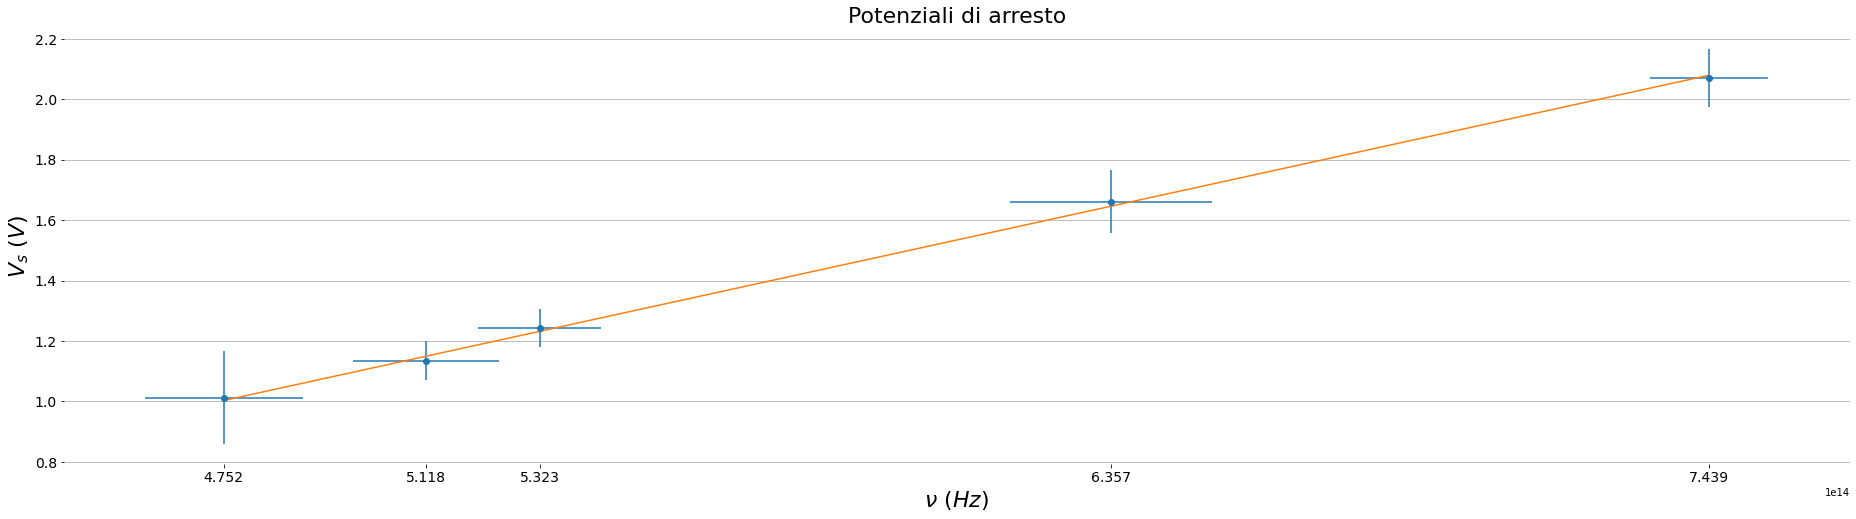

In [9]:
fig, ax1 = plt.subplots(nrows=1, ncols = 1, figsize = (32,8))
ax1.grid(axis = 'y')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.errorbar(x=led['freq'], y=led['intersezione'], xerr=led['err_freq'], yerr=led['err_intersezione'], fmt='o')
sns.lineplot(x=x, y=y, ax=ax1)
ax1.set_ylabel(r'$V_s\ (V)$', fontsize = 22)
ax1.set_xlabel(r'$\nu\ (Hz)$', fontsize = 22)
ax1.set_title('Potenziali di arresto', fontsize=22)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.xaxis.set_major_locator(ticker.FixedLocator(led['freq']))
#plt.savefig('fig1.svg', bbox_inches = "tight")

In [10]:
(output.beta[0]*e-h)/(output.sd_beta[0]*e)

-1.7200608951556595